# Introduction to Flow Models

### Background
Flow models are invertible artificial neural networks that can be used for various tasks including regression, probability densitiy estimation and latent factor disentanglement. Similar to regular neural networks, flow networks can be used for classification, as has been shown for instance for optical character recognition [[4](#References)]. Yet, the real contribuiton lies in the efficient invertibility. As first demonstrated by Rezende and Shakir in the year 2015 [[1](#References)], it is possible to feed a sample from a normal distribution through an inverse flow model to obtain a sample from an arbitrary desired data distribution. It thus allows, for instance, to generate photorealistic pictures of human faces [[2](#References)], animals [[2,3,4](#References)] or furniture [[3](#References)]. Apart from that, flow models compare to principal component analysis, or independent component analysis in that they can be used to disentangle latent factors [[4,5](#References)]. Esser, Rombach and Ommer demonstrated in the year 2020 how complicated manifolds in the latent space of regular artificial neural networks can be decomposed into comprehensive factors. They showed how traversal along those factors corresponds to changes in e.g. a person's hairstyle, smile or gender. Similar work has been done by Liu and colleagues in 2022 on medical images of the heart and brain [[5](#References)]. Flow models are still in their infancy and further experiments are needed to better understand their inner workings. 

### Competences Acquired In This Tutorial 
In this tutorial, the basic modelling cyle will be demonstrated with the help of the flow model package [gyoza](https://gyoza.readthedocs.io/en/latest/). Upon completion, the reader will be able to 
1. explain the basic properties of flow models
2. build sequential flow models with various layers
3. calibrate a model with synthetic data
4. save and load it for distribution 
5. use that model for inference

![Image](https://github.com/TimHenry1995/gyoza/blob/develop/docs/images/Modelling%20Cycle.png?raw=true)

### Gyoza Documentation
At the heart of the gyoza package lays the *flow_layers* module which defines among others, normalization, reflection and coupling layers. The coupling layers rely on standard neural networks which can be constructued manually using [keras](https://keras.io). The *standard_layers* module also offers some keras models for this purpose. Coupling layers also rely on permutation layers (*flow_layer* module) and their corresponding masks (*masks* module). It is recommended to open the [documentation](https://gyoza.readthedocs.io/en/latest/) now in a web browser and read it side-by-side with this tutorial. The corresponding pages will be highlighted in the following sections. 

### Gyoza Installation
The gyoza package is built on top of [tensorflow](https://www.tensorflow.org) and has been developed with a minium number of required packages to simplify installation. It is distributed via the python package index and can thus be installed via pip. In case of installation problems, the reader is invited to contact the developer Tim Dick via [GitHub](https://github.com/TimHenry1995/gyoza/tree/main).

In [2]:
#%pip install gyoza

In [ ]:
from gyoza.modelling import flow_layers as mfl, masks as mm
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, os

from gyoza.tutorials import standard_layers as msl

## Model Building
The model bulding routine involves constructing layers and composing them into more complicated models. The approach is thus similar to that of [tensorflow](https://www.tensorflow.org) and [keras](https://keras.io). For readers unfamiliar with the different types of flow layers, it is recommended to review relevant [literature](#references). In the next code snippets, example data is structured as in image processing and fed through different layers. 

An important aspect of flow layers is that the dimensionality (total number of dimensions spread across all axes) does not change. This is different from regular artificial neural networks which allow for projections from high-dimensional input spaces to low dimensional outputs spaces, e.g. in image classification. A standard approach when modelling with gyoza is to specify along which axes (and corresponding input shape along those axes) the transformations shall be applied. One could for instance limit transformation to spatial, temporal or channel axes. 

Another important aspect of flow layers is their ability to compute their own Jacobian determinant and to provide its own inverse. This is useful for density estimation of probability distributions when working with the change of variables formula during sampling as demonstrated by Dinh, Sohl-Dickstein and Bengio [[3](#references)]. It is also useful for latent factor disentanglement as shown by Esser, Rombach and Ommer [[4](#references)]. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for FlowLayer invert() and compute_jacobian_determinant().*

In [4]:
# Configuration
instance_count = 100; width = 4; height = 4; channel_count = 3
shape = [instance_count, width, height, channel_count]
dimensionality = np.prod(shape[1:])
X = np.random.normal(loc=3, scale=5, size=shape)
Y = X**2 + 3*X - 1

### Activation Normalization

The activation normalization layer uses a location and a scale parameter to perform an affine transformation of the data. These two parameters are initialized on the first batch that is passed through the layer to create zero mean and unit standard deviation. During calibration, these parameters can change to more optimal values. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for ActivationNormalization.*

In [5]:
# Activation Normalization
activation_normalization = mfl.ActivationNormalization(axes=[1,2], shape=[width, height]) # Axes 1,2 are the width and height axes, of the data
Y_hat = activation_normalization(X)

# Print
print("The input to activation normalization has shape (instance count, width, height, channel count): ", X.shape)
print("It has mean {mean:.2f} and standard deviation {std:.2f}".format(mean=np.mean(np.reshape(X,[instance_count, width*height, channel_count])), std=np.std(np.reshape(X,[instance_count, width*height, channel_count]))))
Y_hat = Y_hat = activation_normalization(X)
print("The output of activation normalization has shape (instance count, width, height, channel count): ", Y_hat.shape)
print("It has mean {mean:.2f} and standard deviation {std:.2f}".format(mean=np.mean(np.reshape(Y_hat,[instance_count, width*height, channel_count])), std=np.std(np.reshape(Y_hat,[instance_count, width*height, channel_count]))))

The input to activation normalization has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
It has mean 2.93 and standard deviation 5.09
The output of activation normalization has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
It has mean 0.00 and standard deviation 1.00


### Reflection

The reflection layer uses [Householder reflections](https://en.wikipedia.org/wiki/Householder_transformation) to reflect its input about a reflection axis. A single reflection layer can to multiple reflections in succession which allows for rotation. Inputs are flattened along the shape input before reflection and unflattened afterwards. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Reflection.*

In [6]:
# Reflection
reflection = mfl.Reflection(axes=[3], shape=[channel_count], reflection_count=2)

# Print
print("The input to reflection has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = reflection(X)
print("The output of reflection has shape (instance count, width, height, channel count): ", Y_hat.shape)

The input to reflection has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of reflection has shape (instance count, width, height, channel count):  (100, 4, 4, 3)


### Coupling

The coupling layer is the heart of flow networks in that it allows for non-linear transformations that are still trivially invertible. With the help of a binary mask it takes half of the dimensions of its input. It then uses a regular artificial neural network to compute coupling parameters to transform the other half of input dimensions. That last transformation is usually trivial, e.g. addition or scaling to ensure simple inversion. The first half of input dimensions is then concatenated with that transformed second half and returned as output. It is important to realize, that the layer is trivially invertible, because the first half of the output can be fed through the regular neural network to obtain the very same coupling parameters that were computed in the forward operation. 

Some useful tips for this layer include:
- Ensure that the mask and the coupling layer receive the same axes and shape during construction.
- Choose a model to compute the coupling parameters whose output shape is the same as the input shape. 
- The model for computing coupling parameters should integrate dimensions along the same axes as the mask and coupling layer. That is, if mask and and coupling layer act on a single axis, e.g. the channel axis, then a  dense layer is suited for computing coupling paramters. If a Conv2D layer is used to compute coupling parameters, then mask and coupling layer should act on the same three (2 spatial, one channel) axes as that Conv2D layer.

*Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Coupling, AdditiveCoupling and AffineCoupling, Mask, masks.Heaviside and masks.CheckerBoard.*

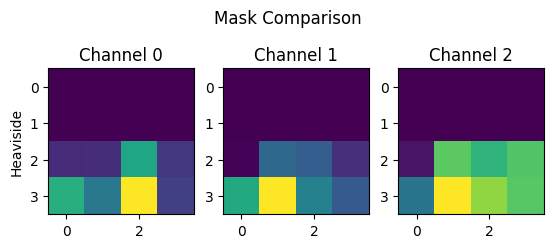

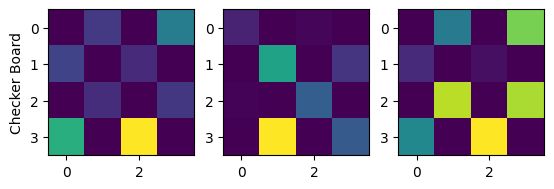

In [7]:
# Set up a mask to select half of the dimensions
heaviside_mask = mm.Heaviside(axes=[1,2,3], shape=[width,height, channel_count])
checker_board_mask = mm.CheckerBoard(axes=[1,2,3], shape=[width,height, channel_count]) # Alternative to Heaviside

# Plot
Y_hat = np.abs(heaviside_mask(X)) # Absolute value is simply for visualization
plt.figure(); plt.suptitle('Mask Comparison'); plt.subplot(2,3,1); plt.ylabel('Heaviside'); plt.title('Channel 0'); plt.imshow(Y_hat[0,:,:,0]); plt.subplot(2,3,2); plt.title('Channel 1'); plt.imshow(Y_hat[0,:,:,1]); plt.subplot(2,3,3); plt.title('Channel 2'); plt.imshow(Y_hat[0,:,:,2]); plt.show()
Y_hat = np.abs(checker_board_mask(X))
plt.subplot(2,3,4); plt.ylabel('Checker Board'); plt.imshow(Y_hat[0,:,:,0]); plt.subplot(2,3,5); plt.imshow(Y_hat[0,:,:,1]); plt.subplot(2,3,6); plt.imshow(Y_hat[0,:,:,2]); plt.show()


In [8]:
# Set up a regular artificial neural network to compute coupling parameters
compute_coupling_parameters = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=(3,3), padding='same')

# Coupling
coupling = mfl.AdditiveCoupling(axes=[1,2,3], shape=[width, height, channel_count], compute_coupling_parameters=compute_coupling_parameters, mask=checker_board_mask)

# Print
print("The input to coupling has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = coupling(X)
print("The output of coupling has shape  (instance count, width, height, channel count): ", Y_hat.shape)

The input to coupling has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of coupling has shape  (instance count, width, height, channel count):  (100, 4, 4, 3)


**Semi-Coupling:** Coupling layers can be used in succession, if they are interleaved with permutation layers. Since a coupling layer couples one half of dimensions with the other half, it performs semi-coupling. To ensure that all dimensions are transformed, it makes sense to permute them between coupling layers. A simple permutation is performed by the Shuffle layer which flattens its input along the provided axes, shuffles it (deterministically) and restores the original shape. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Permutation, Shuffle.*

**Complete Coupling:** In order to achieve coupling across all dimensions (instead of half of them) it makes sense to combine two coupling layers. The first coupling layer is set up as above, followed by a permutation layer that swops dimensions. Thereafter a second coupling layer is used and finally a permutation layer restores the original ordering of dimensions. Some useful tips for this form of coupling include:
- The permutation layer should be matched with the mask of the coupling layer. That is, a Heaviside mask (which selects the second half of dimensions after flattening) should be paired with a Heaside permutation layer. Similarly, a checkerboard mask (which selects every other dimension after flattening) shall be paired with a checkerboard permutation layer. 
- Permutation layers shall match the mask and coupling layers according to the axes and corresponding shape along those axes when processing the input.
- The first and second coupling layers should combine the two halves of dimensions in a similar way, e.g. both being additive or both being affine coupling layers.
- The first and second permutation layers shall be of the same type, e.g. both be Heaviside or both be checkerboard.

*Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Permutation, Heaviside and Checkerboard.*

In [9]:
# Permutation
shuffle_permute = mfl.Shuffle(axes=[1,2,3], shape=[width,height,channel_count])
heaviside_permute = mfl.Heaviside(axes=[1,2,3], shape=[width,height,channel_count])
checkerboard_permute = mfl.CheckerBoard(axes=[1,2,3], shape=[width,height,channel_count])

Y_hat = shuffle_permute(X)
Y_hat = heaviside_permute(X)
Y_hat = checkerboard_permute(X)

# Print
print("The input to permutation has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = shuffle_permute(X)
print("The output of permutation has shape  (instance count, width, height, channel count): ", Y_hat.shape)

The input to permutation has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of permutation has shape  (instance count, width, height, channel count):  (100, 4, 4, 3)


In [10]:
# Second coupling layer
compute_coupling_parameters_2 = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=(3,3), padding='same')
coupling_2 = mfl.AdditiveCoupling(axes=[1,2,3], shape=[width, height, channel_count], compute_coupling_parameters=compute_coupling_parameters_2, mask=checker_board_mask)

### Model Creation

A complete model can be constructucted by arranging the layers in a sequence. The flow_layers module provides a sequential layer which requires a sequence of flow layers as input.

**IMPORTANT:** It is recommended to neither use the Sequential model from keras nor to build custom models with multiple pathways in tensorflow. This is because every gyoza flow layer is able to provide a Jacobian determinant for its forward operation and to invert itself. This functionality would be lost within a keras Sequential model. Within a multi-pathway tensorflow model it is not obvious how to maintain these properties for the overall model and should thus be done by advanced users who have the relevant mathematical background at their disposal.

In [12]:
# Create model
def create_model(width: int, height: int, channel_count: int):
    activation_normalization = mfl.ActivationNormalization(axes=[1,2], shape=[width, height]) 
    reflection = mfl.Reflection(axes=[3], shape=[channel_count], reflection_count=2)
    checker_board_mask = mm.CheckerBoard(axes=[1,2,3], shape=[width,height, channel_count])
    compute_coupling_parameters = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=(3,3), padding='same')
    coupling = mfl.AdditiveCoupling(axes=[1,2,3], shape=[width, height, channel_count], compute_coupling_parameters=compute_coupling_parameters, mask=checker_board_mask)

    return mfl.FlowModel([activation_normalization, reflection, coupling])

model = create_model(width=width, height=height, channel_count=channel_count)

# Print
print("The input to model has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = model(X)
print("The output of model has shape (instance count, width, height, channel count): ", Y_hat.shape)

The input to model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)


## Model Calibration

Gyoza flow models can be calibrated by means of the fit() method. This method can be used on the whole data directly when X,Y and sample_size are provided. Alternatively, an iterator can be provided, for instance if the data is so large that batches need to be loaded from disk one at a time. **Important:** Similar to [keras](https://keras.io/api/models/model_training_apis/), the network needs to be compiled with an [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) and a [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses) before fitting. For some flow models, such as the SupervisedFactorNetwork, gyoza offers particular losses. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for Flowlayer.fit(), SupervisedFactorNetwork, SupervisedFactorLoss.*

Epoch 1/10 - Loss: 4333.1113 - StdDev: 131.1659

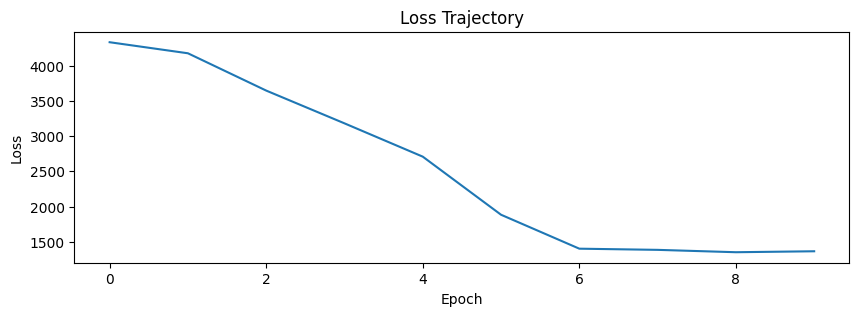

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError())
epoch_loss_means, epoch_loss_standard_deviations = model.fit(epoch_count=10, batch_count=15, X=X, Y=Y, batch_size=32)
plt.figure(figsize=(10,3)); plt.title('Loss Trajectory'); plt.plot(epoch_loss_means); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.show()

## Saving and Loading

In order to store and distribute a model in gyoza, one needs to save its trainable parameters. **Important:** Since not all flow_layers are serializable by the regular [tensorflow](https://www.tensorflow.org/tutorials/keras/save_and_load) protocol it is only possible to save the model parameters but not the entire model. It is thus recommended to wrap the code for model creation in a function that can be called to construct a new model with the same architecture. That new model can then be loaded with the weights that were saved previously. 

In [14]:
# Save existing model
path = "example_model.weights.h5"
model.save_weights(path)

# Initialize a new instance of same architecture
new_model = create_model(width=width, height=height, channel_count=channel_count)
new_model.build(input_shape=X.shape) # Ensures model weights are initialized

# Load weights
new_model.load_weights(path); 
os.remove(path) # The file is no longer needed and deleted to prevent clutter

# Compare
print("The saved and the loaded model weights produce a prediction difference equal to", tf.reduce_sum((model(X)-new_model(X))**2).numpy())

The saved and the loaded model weights produce a prediction difference equal to 0.0


## Model Inference

After the model is distributed, it can be used by other developers or data scientists for inference. The receiver can do so by calling the model on an input of appropriate shape. 

In [15]:
print("The input to the loaded model has shape (instance count, width, height, channel count): ", X.shape)
Y_hat = new_model(X)
print("The output of loaded model has shape (instance count, width, height, channel count): ", Y_hat.shape)

The input to the loaded model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)
The output of loaded model has shape (instance count, width, height, channel count):  (100, 4, 4, 3)


## Next Steps
This was a tutorial on how to use the gyoza modelling framework for flow layers. There are actual experiments performed with gyoza on [GitHub](https://github.com/TimHenry1995/gyoza/tree/main).

## References

[1] ["Variational Inference with Normalizing Flows" by Danilo Jimenez Rezende and Shakir Mohamed](https://arxiv.org/abs/1505.05770)

[2] ["Glow: Generative Flow with Invertible 1×1 Convolutions" by Diederik P. Kingma, Prafulla Dhariwal](https://arxiv.org/abs/1807.03039)

[3] ["DENSITY ESTIMATION USING REAL NVP" by Laurent Dinh, Jascha Sohl-Dickstein, Samy Bengio](https://arxiv.org/abs/1605.08803)

[4] ["A Disentangling Invertible Interpretation Network for Explaining Latent Representations" by Patrick Esser, Robin Rombach, Björn Ommer](https://arxiv.org/abs/2004.13166)

[5] ["Learning disentangled representations in the imaging domain" by Xiao Liu, Pedro Sanchez, Spyridon Thermos, Alison Q. O'Neil, Sotirios A. Tsaftaris](https://arxiv.org/abs/2108.12043)